In [29]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avomo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load data and some analysis

In [2]:
df = pd.read_csv('../data/raw/Reviews.csv', nrows=10000)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
print("Duplicated rows : ", df.duplicated().sum())
print("Nan values : ", df.isna().sum())

Duplicated rows :  0
Nan values :  Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


### Preprocessing

In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [5]:
df['Text'][:10]

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object

we will clean the dataset by :
* lower case all word
* remove html tags
* contraction mapping
* remove -> 's <-
* remove ponctuation and special characters
* remove stopwords
* remove short words


In [6]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    #lowercase
    final_text = text.lower()

    #remove html tag
    final_text = BeautifulSoup(final_text, 'lxml').text

    #remove special characters
    final_text = re.sub(r'\([^)]*\)', '', final_text)
    final_text = re.sub('"', '', final_text)
    final_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in final_text.split(" ")])
    final_text = re.sub("'s\b", "", final_text)
    final_text = re.sub("[^a-zA-Z]", " ", final_text)

    #remove stopwords
    tokens = [w for w in final_text.split() if not w in stop_words]

    #remove short words
    long_words = [t for t in tokens if len(t)>= 3]

    return (" ".join(long_words)).strip()


In [7]:
df['Cleaned_text'] = df['Text'].apply(clean_text)

In [9]:
#summary
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    long_tokens = [t for t in tokens if len(t)>1]
    newString = ' '.join(long_tokens).strip()
    return newString

In [15]:
df['cleaned_summary'] = df['Summary'].apply(summary_cleaner)
df['cleaned_summary'].replace('', np.nan, inplace=True)
df.dropna(axis = 0, inplace = True)

#add special token for start and end
df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x: '_START_ ' + x + ' _END_')

In [16]:
#lets us check the structure
for i in range(5):
    print('Review : ', df['Cleaned_text'] [i] )
    print('Summary : ', df['cleaned_summary'][i])
    print('\n')

Review :  bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary :  _START_ good quality dog food _END_


Review :  product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary :  _START_ not as advertised _END_


Review :  confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary :  _START_ delight says it all _END_


Review :  looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary :  _START_ cough medicine _END_


Review :  great taffy great price wide assortment yummy taffy delivery 

### Some analysis of text

In [17]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

df['text_word_count'] = df['Cleaned_text'].apply(lambda x: len(x.split()))
df['summary_word_count'] = df['cleaned_summary'].apply(lambda x: len(x.split()))



*********** Text ************
count    9991.000000
mean       36.079972
std        33.911362
min         4.000000
25%        16.000000
50%        26.000000
75%        44.000000
max       839.000000
Name: text_word_count, dtype: float64

 ************ Summary ************
count    9991.00000
mean        5.93304
std         2.45272
min         3.00000
25%         4.00000
50%         5.00000
75%         7.00000
max        27.00000
Name: summary_word_count, dtype: float64

 



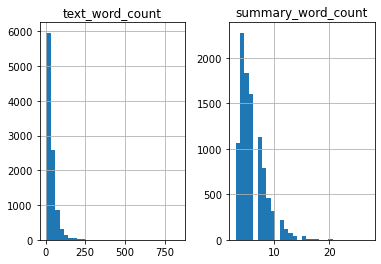

In [24]:
print("*********** Text ************")
print(df['text_word_count'].describe())
print("\n ************ Summary ************")
print(df['summary_word_count'].describe())

print("\n \n")

_ = df[['text_word_count', 'summary_word_count']].hist(bins = 30)

So we can set the text max length as 80 and summary as 10

In [26]:
MAX_LEN_TEXT = 80
MAX_LEN_SUMMARY = 10

In [27]:
#split the test and training set
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df['Cleaned_text'], df['cleaned_summary'], test_size=0.1, random_state=77, shuffle=True)

In [30]:
#tokenizer
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

#convert the train to tokens
x_train = x_tokenizer.texts_to_sequences(x_train)
x_val = x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximal length
x_train = pad_sequences(x_train, maxlen=MAX_LEN_TEXT, padding='post')
x_val  = pad_sequences(x_val, maxlen=MAX_LEN_TEXT, padding='post')

#vocabulary size
x_vocab_size = len(x_tokenizer.word_index) + 1


In [31]:
## Tokenize summary
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert to tokens
y_train = y_tokenizer.texts_to_sequences(y_train)
y_val = y_tokenizer.texts_to_sequences(y_val)

#padding
y_train = pad_sequences(y_train, maxlen=MAX_LEN_SUMMARY, padding='post')
y_val = pad_sequences(y_val, maxlen=MAX_LEN_SUMMARY, padding='post')

#covabulary size
y_vocab_size = len(y_tokenizer.word_index) + 1


## Modeling

In [ ]:
from keras import backend as K
K.clear_session()

